In [1]:
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from utils import load_image
from imutils.paths import list_images
from pprint import pprint

from scipy.spatial.distance import euclidean

In [4]:
json_dict = {
    'flickr': './json_data/FLICKR.json',
    'splunk': './json_data/Splunk.json',
}

datasets = {
    'flickr': '/media/choppy/WD_BLACK/datasets',
    'splunk': '/media/choppy/WD_BLACK/datasets',
}

# 0. contar cuantas imagenes pasaron por el detector y explicar por que las otras no

In [14]:
for json_key in json_dict.keys():
    js = json.load(open(json_dict[json_key]))
    print(f'Length of dataset {json_key}: {len(js)}\n')
    
    attacks = []
    bonafide = []
    
    for elem in js:
        # pprint(elem)
        split = elem.get('image_dir').split(os.sep)
        if split[1] == 'attack':
            attacks.append(elem)
        else:
            bonafide.append(elem)
    
    print(f'bonafide len: {len(bonafide)}')
    print(f'attack len: {len(attacks)}\n\n')
    
    # break

Length of dataset flickr: 13975

bonafide len: 3000
attack len: 10975


Length of dataset splunk: 24930

bonafide len: 5997
attack len: 18933




In [6]:
# agrupar imagenes y metadata en bonafide vs ataque y contar cuantas imagenes pasaron vs cuantas deberian ser
# generar array con indices de imagenes por cada dataset y guardarlo

In [7]:
len(bonafide), len(attacks)

(3000, 10975)

In [8]:
elem.get('mtcnn-inference').get('keypoints')

{'left_eye': [410, 490],
 'right_eye': [610, 480],
 'nose': [450, 610],
 'mouth_left': [430, 770],
 'mouth_right': [570, 760]}

In [8]:
elem.get('mtcnn-inference')['box']

[430, 1300, 1780, 2370]

ye


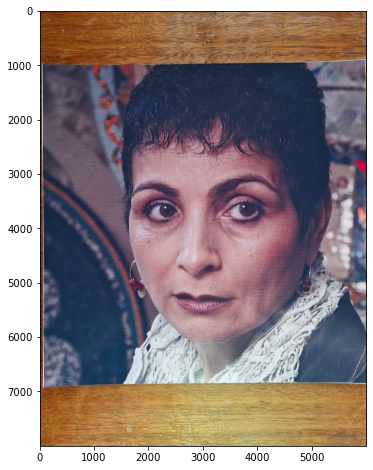

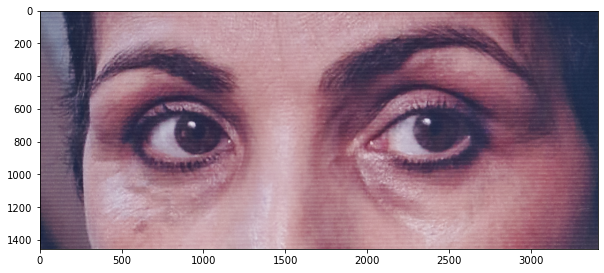

ye


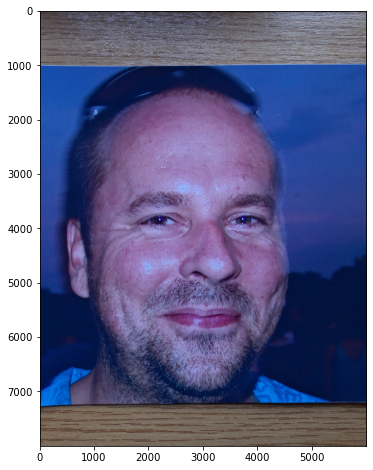

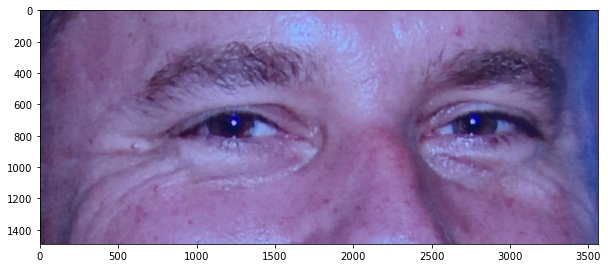

In [18]:
# calcular area, ancho y largo de zonas perioculares

i = 0

for json_key in json_dict:
    js = json.load(open(json_dict[json_key]))
    
    for elem in js:
        imdir = elem.get('image_dir')
        imdir = os.path.join(datasets[json_key], imdir)
        # print(imdir)
        
        if os.path.isfile(imdir):
            print('ye')
            image = load_image(imdir)
            
            # get bbox from elem
            bbox = elem.get('mtcnn-inference').get('box')
            
            
            
            nose = elem.get('mtcnn-inference').get('keypoints').get('nose')
            left_eye, right_eye = elem.get('mtcnn-inference').get('keypoints')['left_eye'], elem.get('mtcnn-inference').get('keypoints')['right_eye']
            dst1, dst2 = euclidean(left_eye, nose), euclidean(right_eye, nose)
            mean_dst = np.mean([dst1, dst2]).astype(np.uint16)

            periocular = image.copy()

            pt1 = (bbox[0], left_eye[1]-int(mean_dst*0.6))
            pt2 = (bbox[0]+bbox[2], right_eye[1]+int(mean_dst*0.6))


            periocular = periocular[ pt1[1]:pt2[1], pt1[0]:pt2[0], ... ] # use the generated points to crop the ROI

            # face + distance
            # periocular = cv2.rectangle(periocular, pt1, pt2, color=[255, 0, 0], thickness=50)

            
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.show()
            
            plt.figure(figsize=(10, 8))
            plt.imshow(periocular)
            plt.show()
            i += 1
            if i == 2: break
        else:
            continue
        
    break

In [19]:
# 1. agrupar imagenes en bonafide vs atk1 vs atk2 vs atk_n

In [61]:
words = np.array([a['image_dir'].split(os.sep) for a in attacks]).flatten()

In [62]:
unique_words = np.unique(words)

In [63]:
unique_words.shape

(18957,)

In [64]:
unique_words.tolist()

['  S2752_screen_tablet_mano_20220704215549.jpg',
 '998_screen_smartphone_mano_RONDA7',
 'RONDA7_SPLUNK_PA',
 'S1000_print_opaco_curvado_20220630010529.jpg',
 'S1000_print_opaco_plano_20220527015314.jpg',
 'S1000_screen_computador_fijo_20220531212414.jpg',
 'S1001_print_brillante_curvado_20220501234719.jpg',
 'S1001_print_brillante_plano_20220428232429.jpg',
 'S1001_screen_smartphone_fijo_20220415155052.jpg',
 'S1001_screen_smartphone_mano_20220423000820.jpg',
 'S1002_print_brillante_curvado_20220501234756.jpg',
 'S1002_print_brillante_plano_20220428232356.jpg',
 'S1002_screen_smartphone_fijo_20220415155400.jpg',
 'S1002_screen_smartphone_mano_20220423000849.jpg',
 'S1003_print_brillante_curvado_20220501024948.jpg',
 'S1003_print_brillante_plano_20220428232332.jpg',
 'S1003_screen_smartphone_fijo_20220417222000.jpg',
 'S1003_screen_smartphone_mano_20220423000910.jpg',
 'S1004_print_brillante_curvado_20220501025024.jpg',
 'S1004_print_brillante_plano_20220428232310.jpg',
 'S1004_screen_

In [ ]:
# TODO:

# 1. agrupar imagenes en bonafide vs atk1 vs atk2 vs atk_n
# 1.1. ojala bonafide sea una carpeta con carpetas y los impostores sean tambien una carpeta con carpetas

# 2. respetar metodologia de entrenamiento
# primero caras -> recortarlas
# despues periocular